Group 4 Members

* Shyam Akhil Nekkanti - 8982123
* Jun He (Helena) - 8903073
* Zheming Li (Brendan) - 8914152

### Dataset Description

ONLY USING US DATA

/var/folders/l7/z_g7053948z2cyzhzs9wvfg40000gn/T/ipykernel_77786/1897282634.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Loaded 40949 records

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                40949 non-null  object             
 1   trending_date           40949 non-null  datetime64[ns]     
 2   title                   40949 non-null  object             
 3   channel_title           40949 non-null  object             
 4   category_id             40949 non-null  int64              
 5   publish_time            40949 non-null  datetime64[ns, UTC]
 6   tags                    40949 non-null  object             
 7   views                   40949 non-null  int64              
 8   likes                   40949 non-null  int64              
 9   dislikes                40949 non-null  int64              
 10  comment_count           40949 non-null  int64              
 11  t

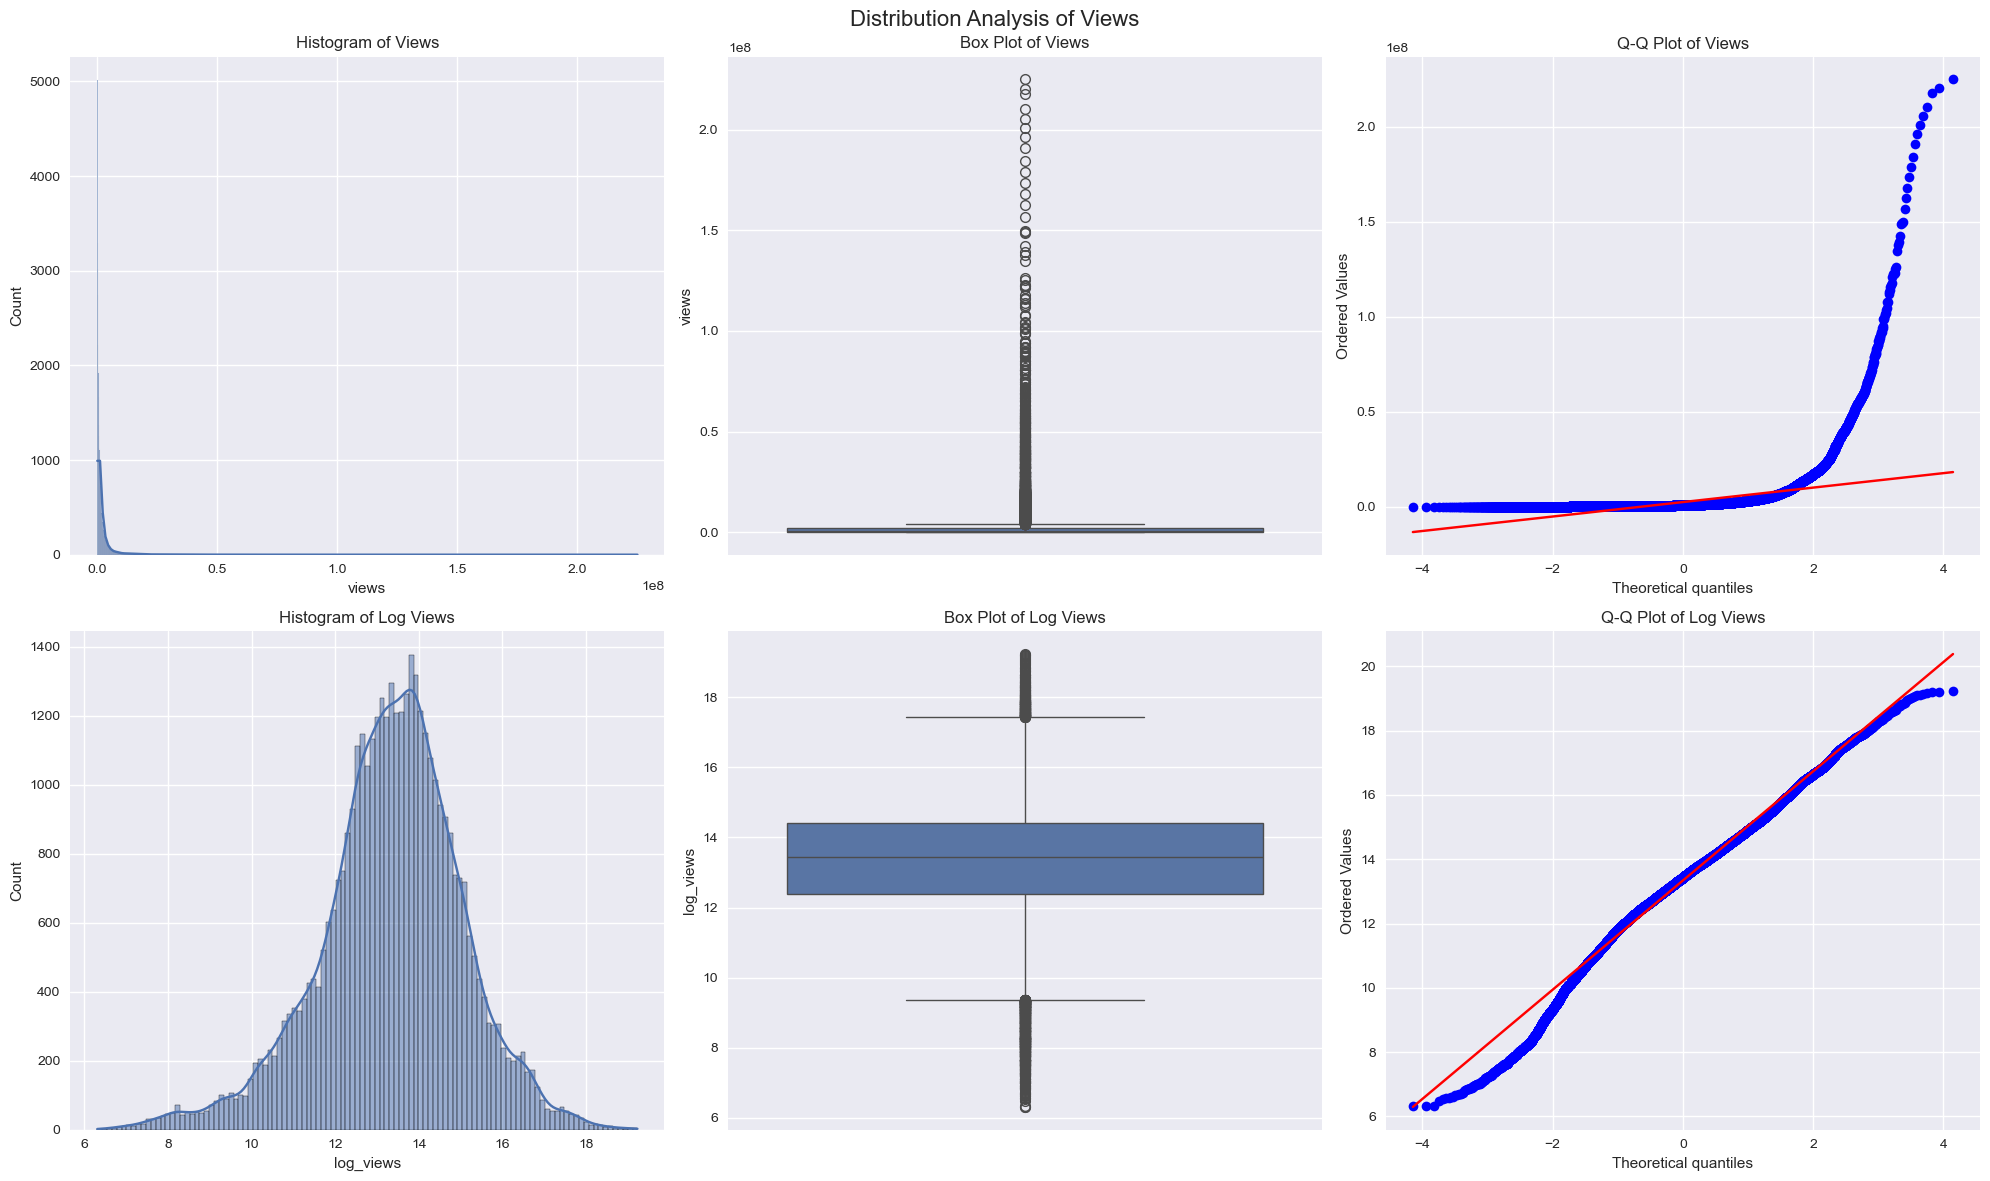

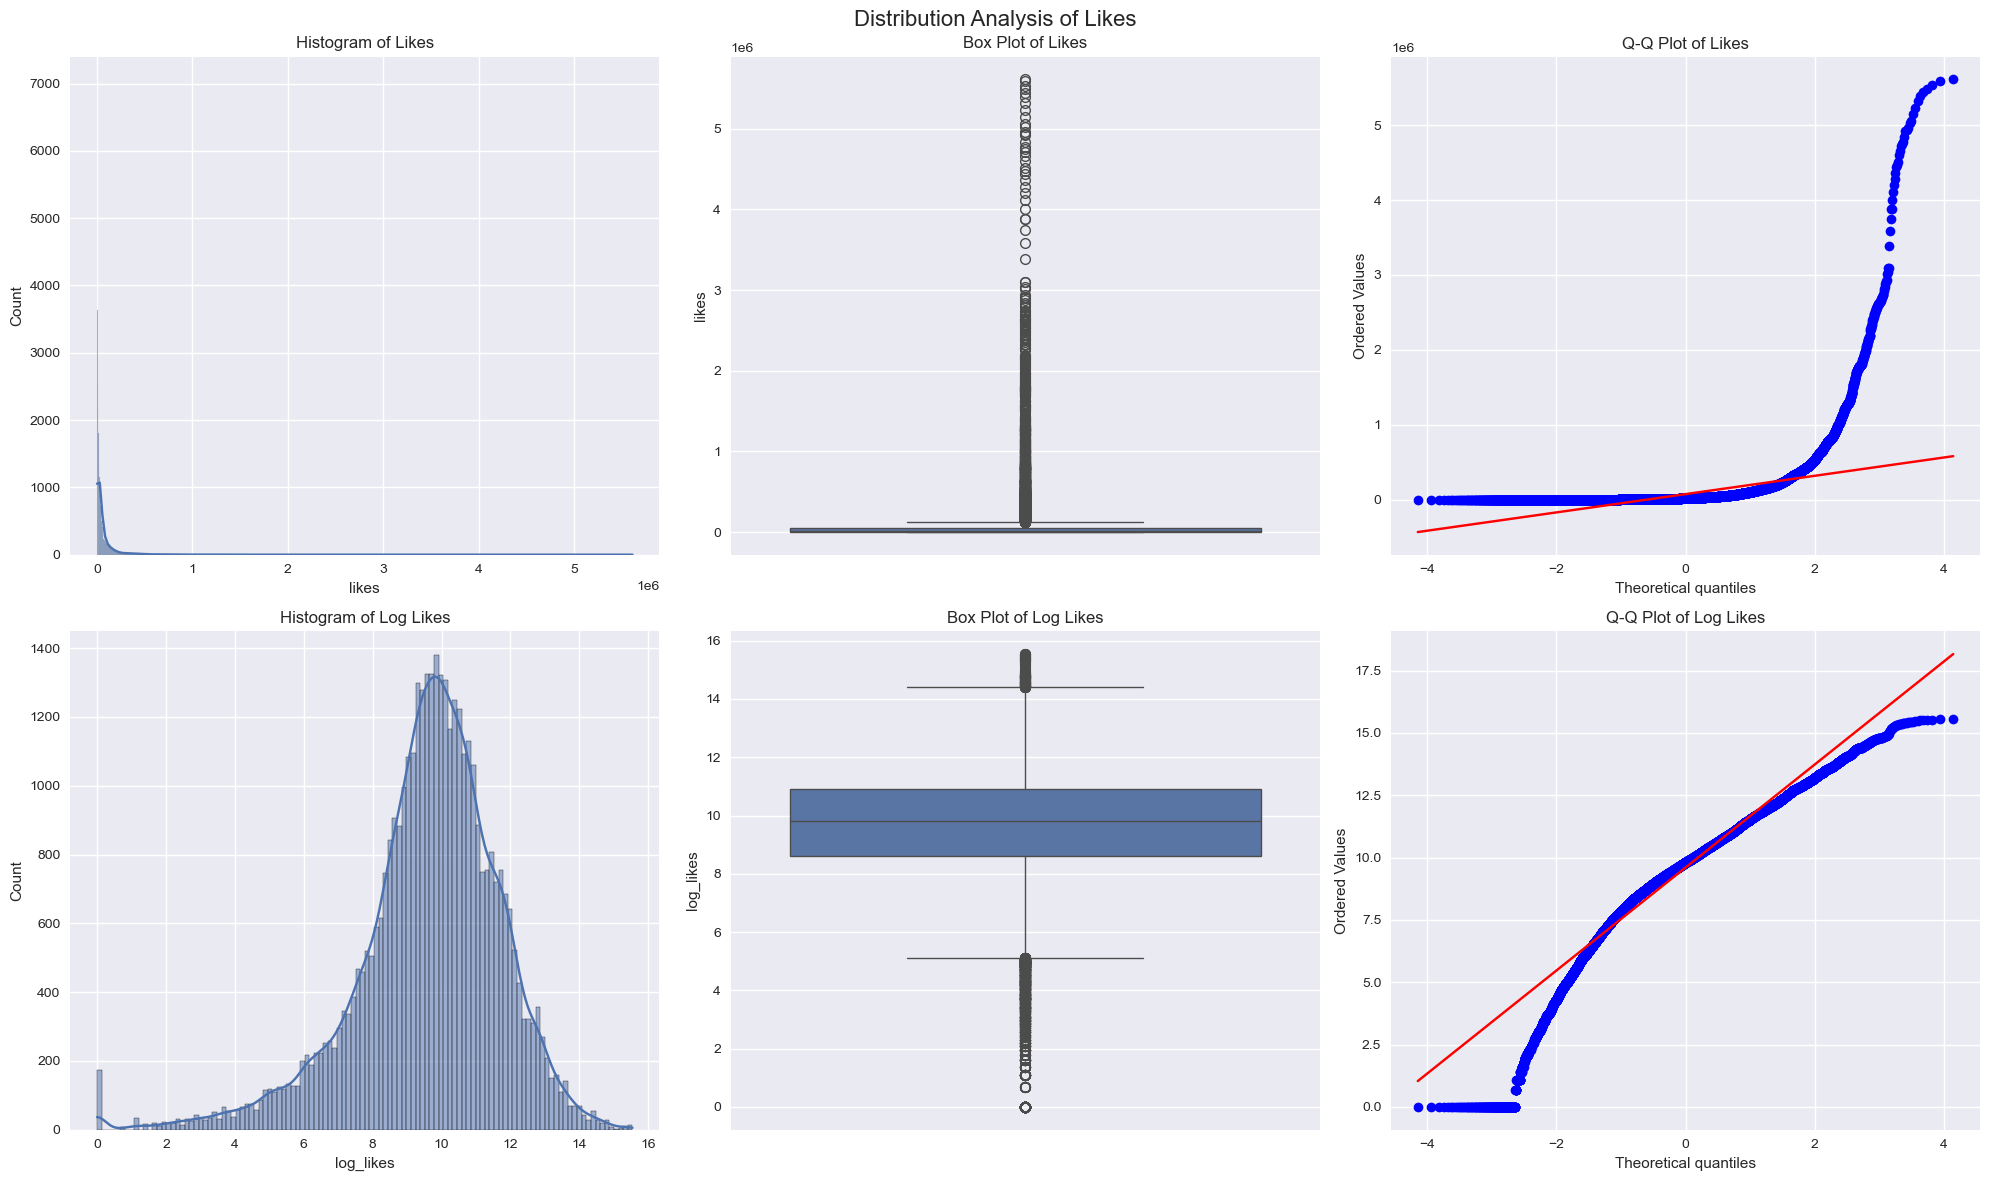

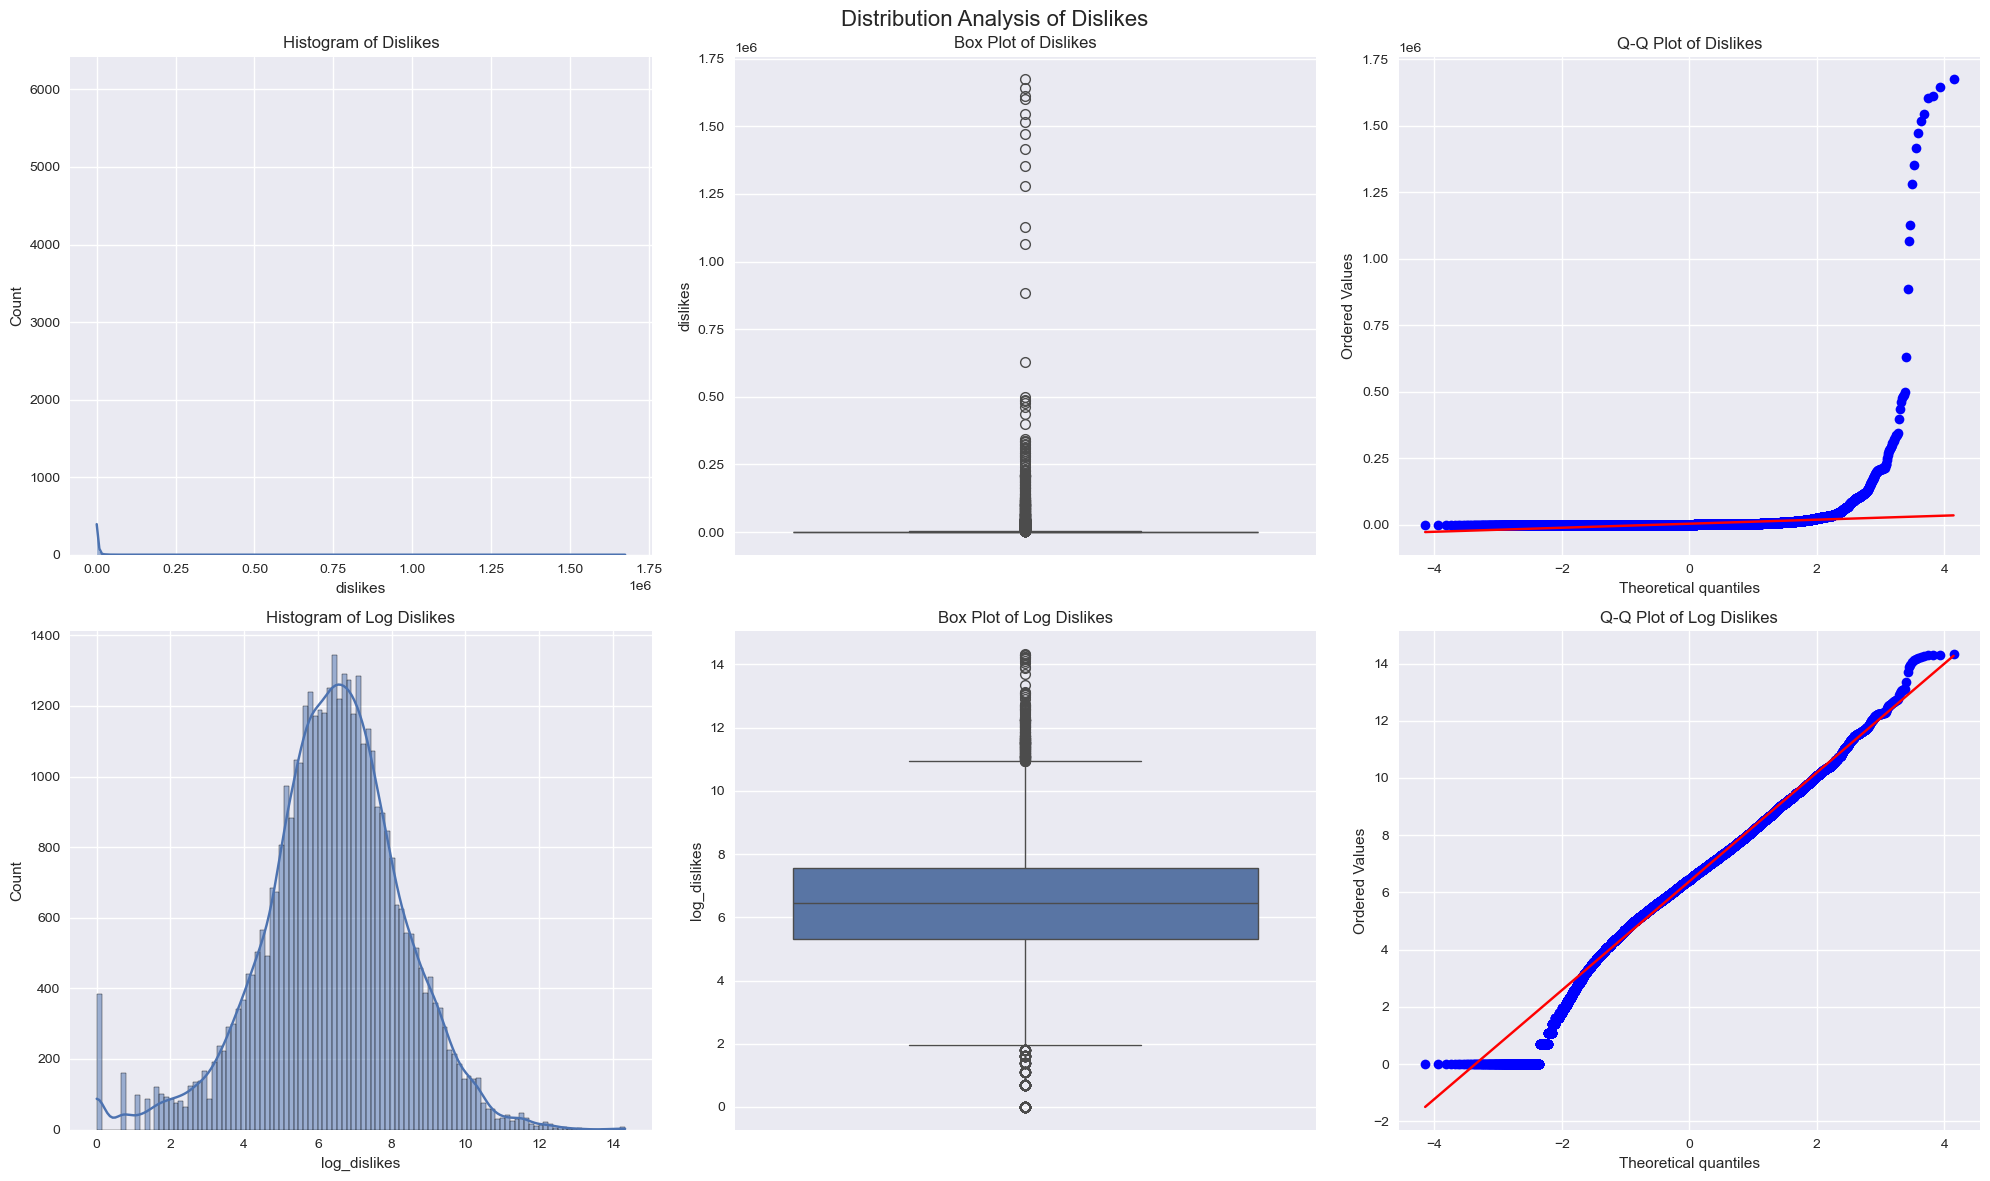

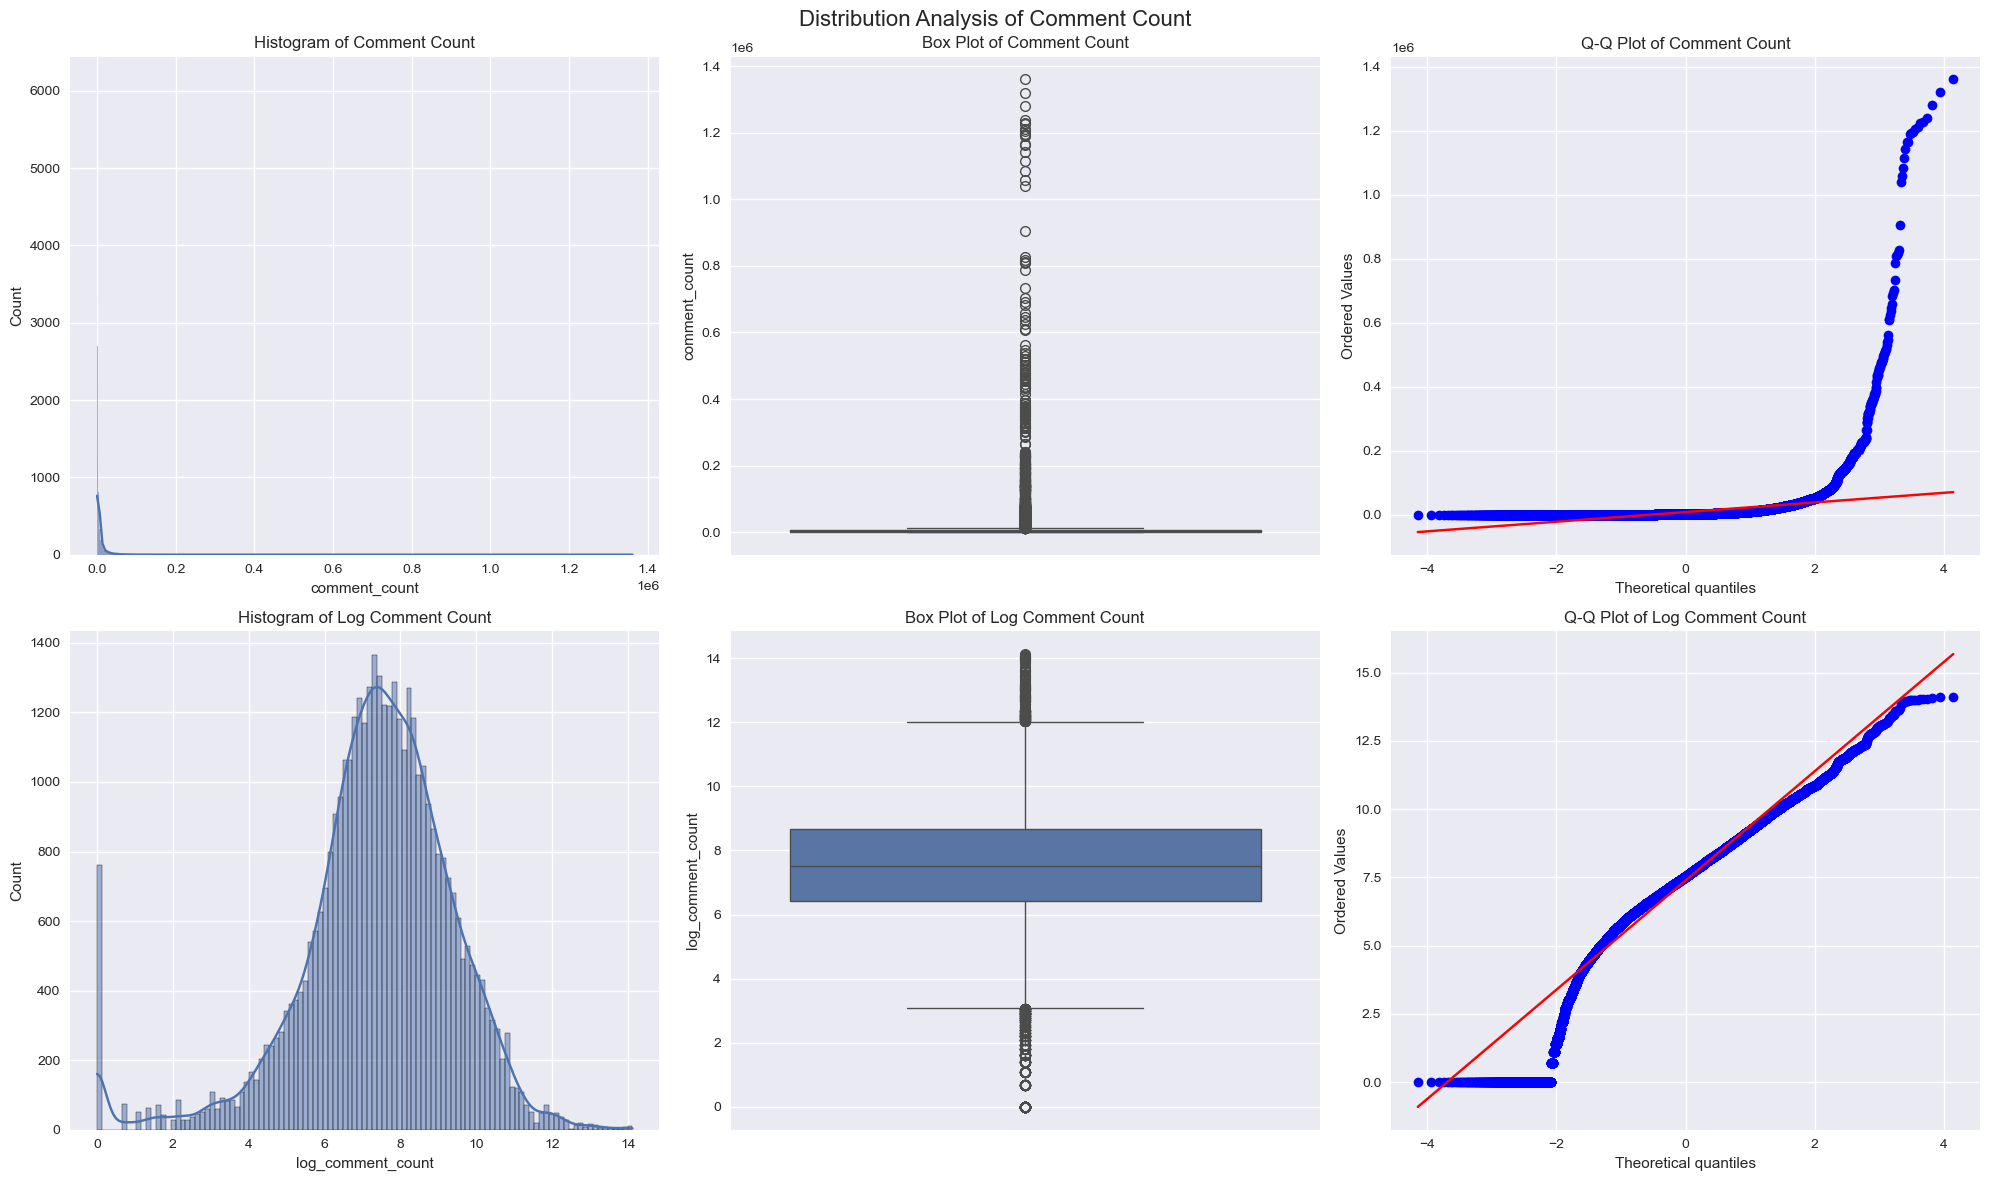

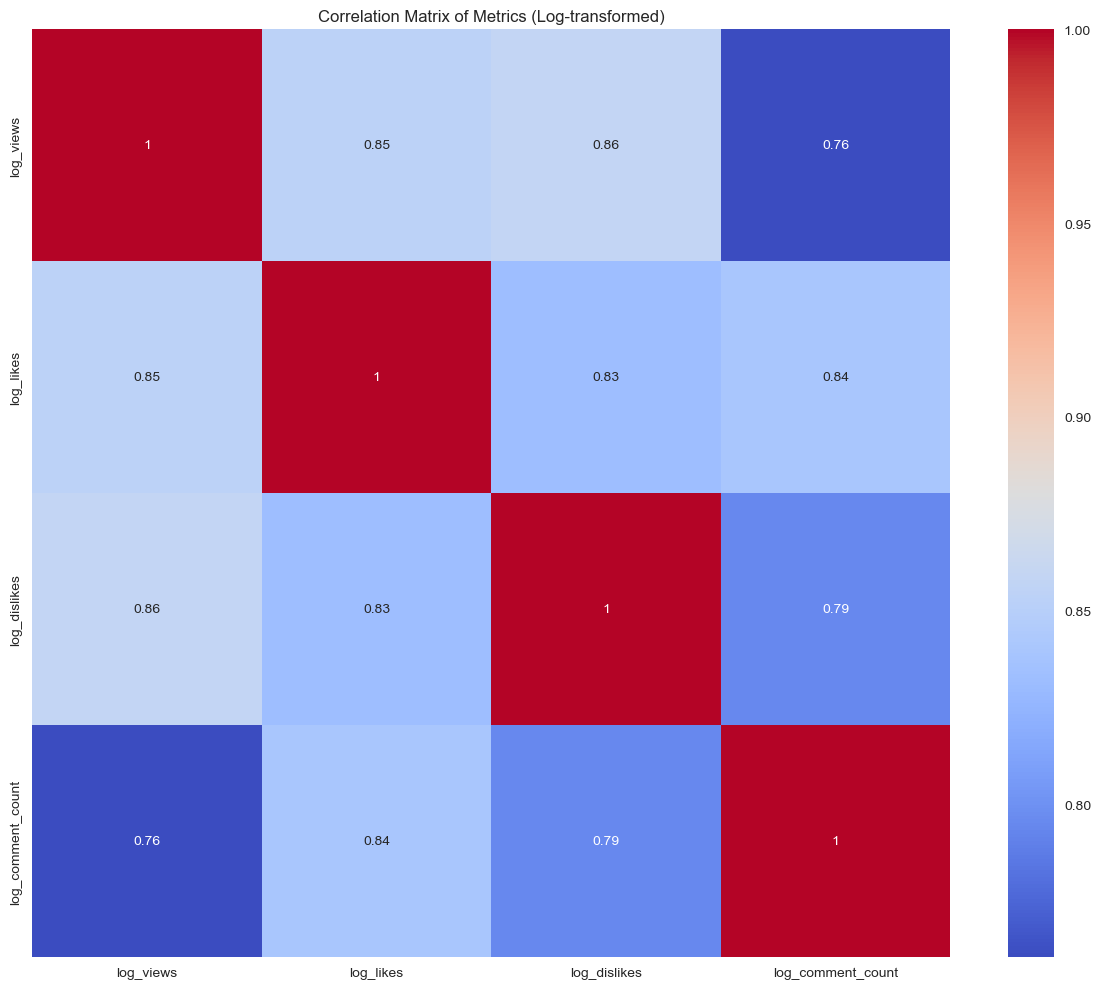


Category Analysis
                            views                              likes           \
                             mean     median          std       mean   median   
category_name                                                                   
Autos & Vehicles       1355965.41   406278.0   3373464.36   11056.40   5916.0   
Comedy                 1480308.42   980236.0   2009898.63   62582.22  30214.0   
Education               712940.82   419440.5    879267.63   29745.03  13508.5   
Entertainment          2067883.20   734704.0   5815995.95   53243.33  16234.0   
Film & Animation       3106250.20  1274578.0   5576254.91   70787.84  25176.0   
Gaming                 2620830.63  1494142.0   3165317.91   84502.18  51057.0   
Howto & Style           983730.12   502783.0   1928994.99   39286.08  21492.5   
Music                  6201003.12  1434128.0  15459879.47  218918.20  62280.5   
News & Politics         592587.74   244014.0   1118917.93    7298.36   1920.0   
Nonprofit

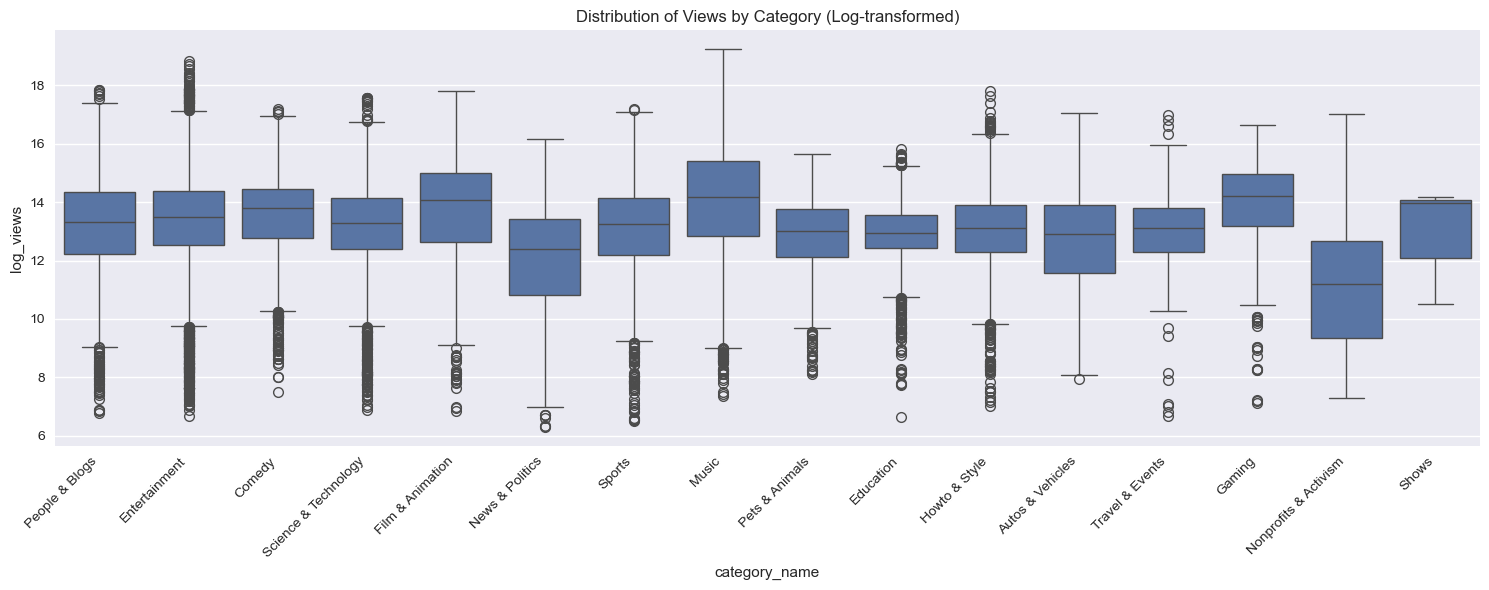

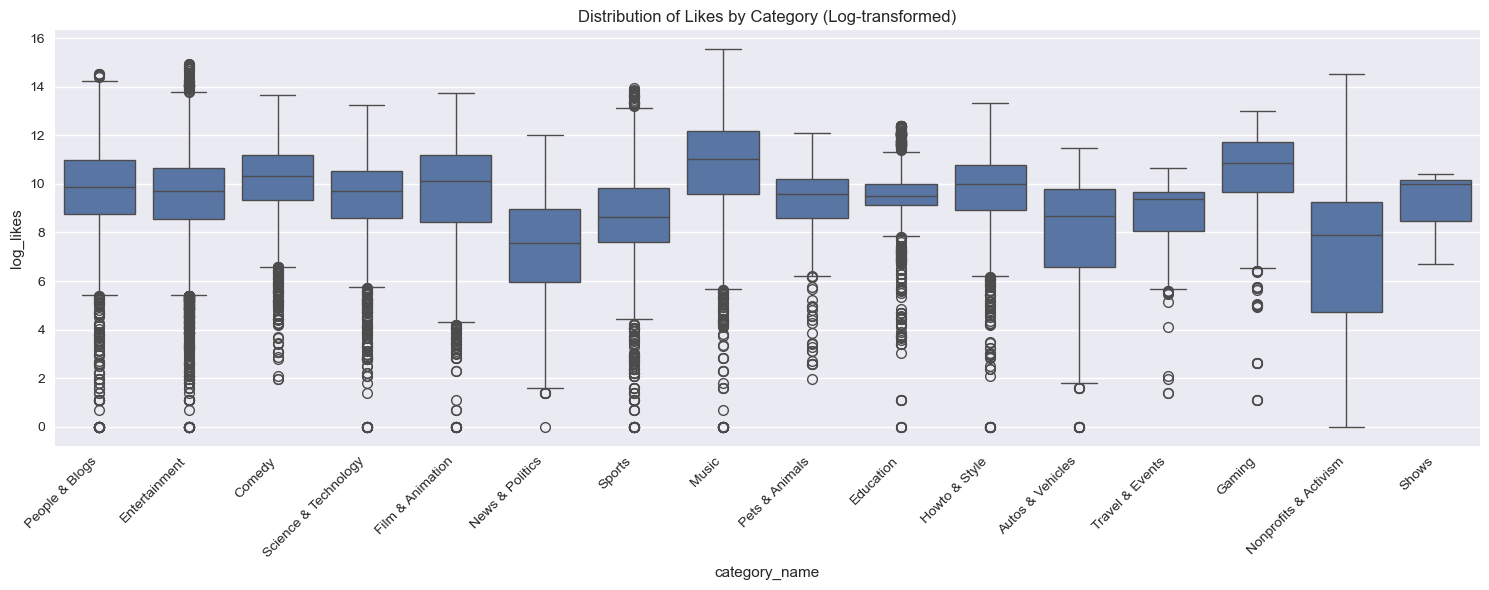

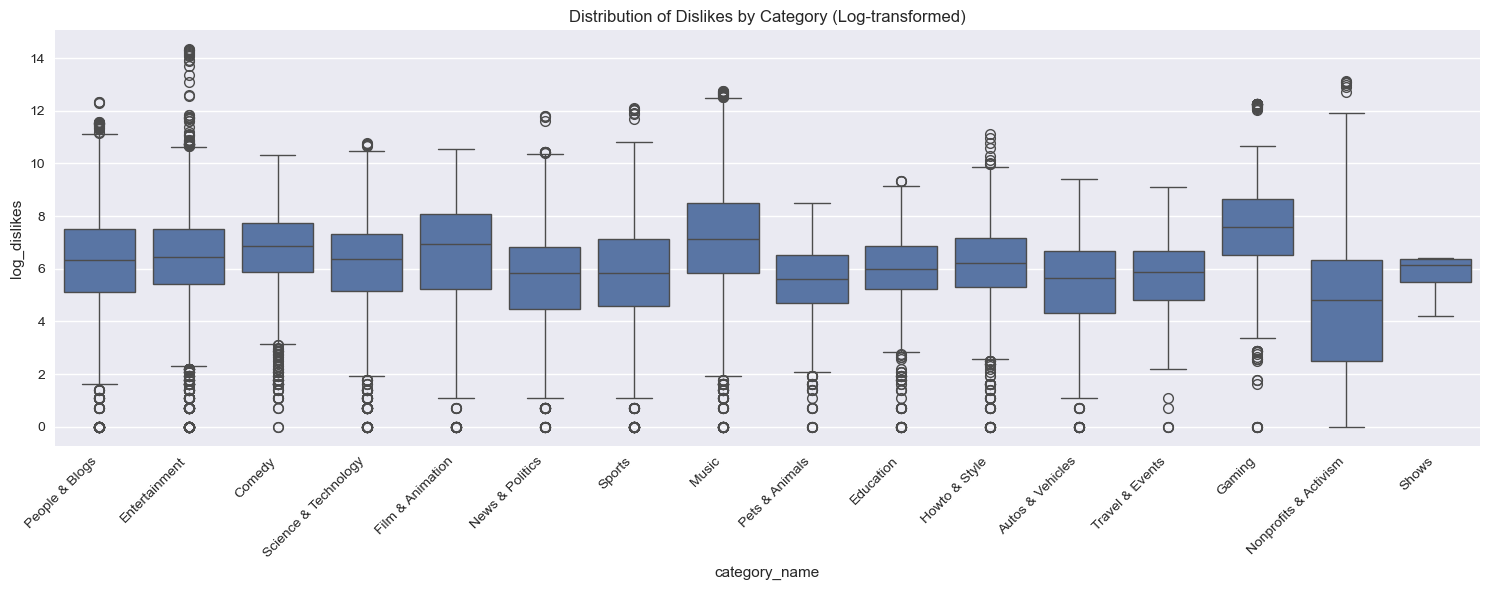

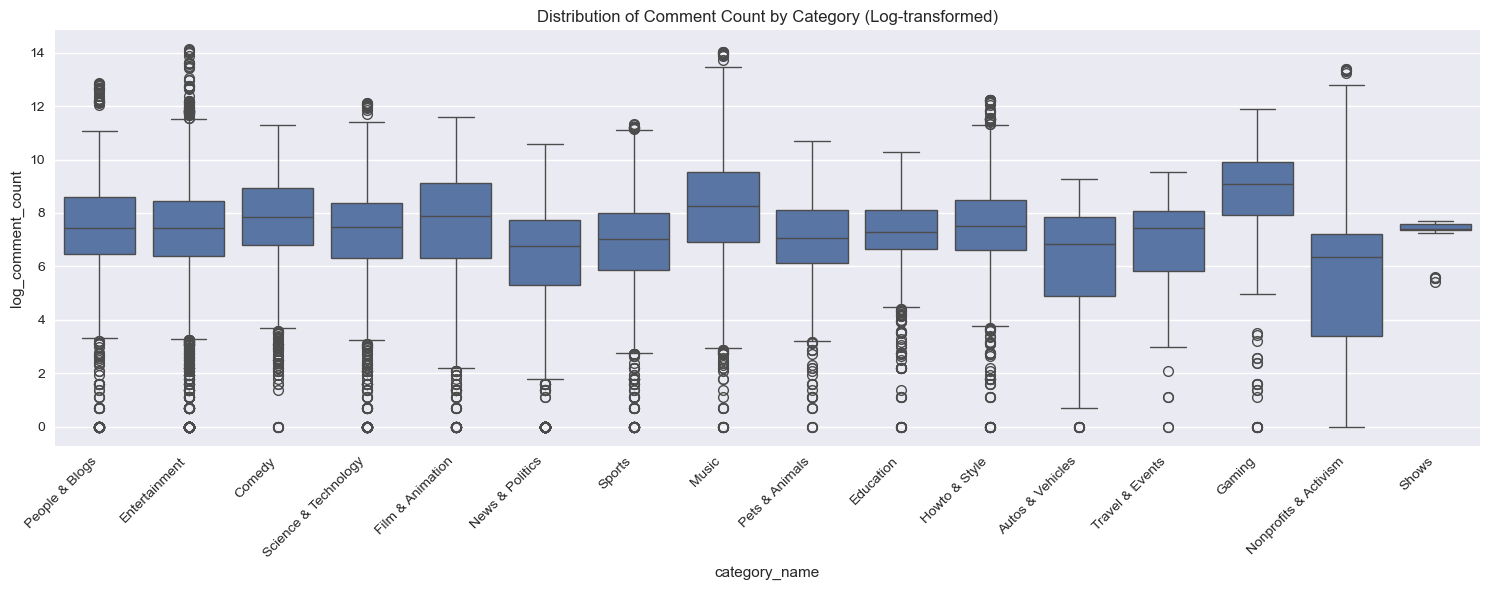

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from scipy.stats import shapiro, normaltest

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

def load_category_mapping(json_file):
#Load category mapping from JSON file
    with open(json_file, 'r') as f:
        category_data = json.load(f)
    formatted_categories = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
    return formatted_categories

def load_and_preprocess_data(csv_file, category_mapping):
#Load and preprocess the YouTube dataset
    df = pd.read_csv(csv_file)
    
    # Convert dates
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
    df['publish_time'] = pd.to_datetime(df['publish_time'])
    
    # Add category names column 
    df['category_name'] = df['category_id'].map(category_mapping)
    
    # Create log-transformed columns for numerical features
    numerical_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numerical_cols:
        df[f'log_{col}'] = np.log1p(df[col])
    
    # Add derived metrics
    df['likes_ratio'] = df['likes'] / (df['views'] + 1)
    df['dislikes_ratio'] = df['dislikes'] / (df['views'] + 1)
    df['comment_ratio'] = df['comment_count'] / (df['views'] + 1)
    
    return df

def plot_distribution_analysis(data, column, log_column, title):
#Create plots for both original and log-transformed data
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Distribution Analysis of {title}', fontsize=16)
    
    # Original data plots
    sns.histplot(data[column], kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Histogram of {title}')
    
    sns.boxplot(y=data[column], ax=axes[0,1])
    axes[0,1].set_title(f'Box Plot of {title}')
    
    stats.probplot(data[column], dist="norm", plot=axes[0,2])
    axes[0,2].set_title(f'Q-Q Plot of {title}')
    
    # Log-transformed data plots
    sns.histplot(data[log_column], kde=True, ax=axes[1,0])
    axes[1,0].set_title(f'Histogram of Log {title}')
    
    sns.boxplot(y=data[log_column], ax=axes[1,1])
    axes[1,1].set_title(f'Box Plot of Log {title}')
    
    stats.probplot(data[log_column], dist="norm", plot=axes[1,2])
    axes[1,2].set_title(f'Q-Q Plot of Log {title}')
    
    plt.tight_layout()
    return fig

def analyze_metric(data, metric):
#Analysis of a metric, both original and log-transformed
    log_metric = f'log_{metric}'
    
    subsample = data.sample(n=1000, random_state=42) #taking a subsample of 1000 entries for the Shapiro-Wilk test

    # Original data statistics
    orig_stats = data[metric].describe()
    orig_shapiro = shapiro(subsample[metric])
    orig_normaltest = normaltest(data[metric])
    
    # Log-transformed statistics
    log_stats = data[log_metric].describe()
    log_shapiro = shapiro(subsample[log_metric])
    log_normaltest = normaltest(data[log_metric])
    
    return {
        'original': {
            'statistics': orig_stats,
            'shapiro_test': orig_shapiro,
            'normaltest': orig_normaltest
        },
        'log_transformed': {
            'statistics': log_stats,
            'shapiro_test': log_shapiro,
            'normaltest': log_normaltest
        }
    }

# Load dataset
category_mapping = load_category_mapping('youtube-dataset/US_category_id.json')
df = load_and_preprocess_data('youtube-dataset/USvideos.csv', category_mapping)
print(f"Loaded {len(df)} records")

print("\nDataset Overview:")
print(df.info())

# Main features we are considering
metrics = ['views', 'likes', 'dislikes', 'comment_count']

for metric in metrics:
    print(f"\n{'='*50}")
    print(f"Analysis for {metric.upper()}")
    print(f"{'='*50}")
    
    # Create visualization
    fig = plot_distribution_analysis(df, metric, f'log_{metric}', metric.replace('_', ' ').title())
    
    # Perform analysis
    analysis_results = analyze_metric(df, metric)
    
    # Print results
    print("\nOriginal Data Statistics:")
    print(analysis_results['original']['statistics'])
    print(f"Shapiro-Wilk test: statistic={analysis_results['original']['shapiro_test'][0]:.4f}, p-value={analysis_results['original']['shapiro_test'][1]:.4e}")
    print(f"D'Agostino-Pearson test: statistic={analysis_results['original']['normaltest'][0]:.4f}, p-value={analysis_results['original']['normaltest'][1]:.4e}")
    
    print("\nLog-Transformed Data Statistics:")
    print(analysis_results['log_transformed']['statistics'])
    print(f"Shapiro-Wilk test: statistic={analysis_results['log_transformed']['shapiro_test'][0]:.4f}, p-value={analysis_results['log_transformed']['shapiro_test'][1]:.4e}")
    print(f"D'Agostino-Pearson test: statistic={analysis_results['log_transformed']['normaltest'][0]:.4f}, p-value={analysis_results['log_transformed']['normaltest'][1]:.4e}")

# 1. Correlation Analysis
print("\nCorrelation Analysis")
print("="*50)
correlation_matrix = df[[f'log_{m}' for m in metrics]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Metrics (Log-transformed)')
plt.tight_layout()
plt.show()

# 2. Category Analysis
print("\nCategory Analysis")
print("="*50)
category_metrics = df.groupby('category_name')[metrics].agg(['mean', 'median', 'std']).round(2)
print(category_metrics)

# Plot category comparisons
for metric in metrics:
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='category_name', y=f'log_{metric}', data=df)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Distribution of {metric.replace("_", " ").title()} by Category (Log-transformed)')
    plt.tight_layout()
    plt.show()